In [1]:

import sys
import os
# setting path
current = os.path.dirname(os.path.realpath('__file__'))
parent = os.path.dirname(current)
sys.path.append(parent)


import brainpy as bp
import brainpy.math as bm

from types import SimpleNamespace
from utils import *

from calc_params import par, update_parameters
from model import Model

c:\Users\dell\anaconda3\envs\brainpy-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing Parameters...


In [2]:
f_dir = "test_output_full_model"
lr = 0.02
rep = 0
update_parameters({'rep': rep,
                    'save_fn': 'model_results_%d_lr%f.pkl' % (rep, lr),
                    'batch_size': par['test_batch_size'],
                    'num_iterations': par['num_test_iterations'],
                    'coherence_levels': par['test_coherence_levels'],
                    'weight_fn': 'weight_%d.pth' % (rep),
                    'learning_rate': lr, 
                    'save_test_out': False})

In [3]:
n = SimpleNamespace(**load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)))
normalized_h = min_max_normalize(n.h)
normalized_h.shape

(70, 2048, 200)

In [4]:
n.syn_x.shape

(70, 2048, 200)

In [5]:
#TODO: slow point for each time point
model = Model(par, n.neural_input, train=False)
model.reset_batch()
# model.temp_h = bm.Variable(model.h[0, :])
# finder = bp.analysis.SlowPointFinder(model, args = (n.neural_input[45, 0, :],), target_vars={'h':model.h, 'syn_x':model.syn_x, 'syn_u':model.syn_u})

In [36]:
finder_li = []
for t in range(45, 70):
    fp_c_h = n.h[t, :, :]
    fp_c_synx = n.syn_x[t, :, :]
    fp_c_synu = n.syn_u[t, :, :]
    fp_candidates = {'h': fp_c_h, 'syn_x': fp_c_synx, 'syn_u': fp_c_synu}
    finder = bp.analysis.SlowPointFinder(model, args = (n.neural_input[t, 0, :],), target_vars={'h':model.h, 'syn_x':model.syn_x, 'syn_u':model.syn_u})
    finder.find_fps_with_gd_method(candidates=fp_candidates, num_batch=500)
    finder_li.append(finder)

Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 3.69 sec, Training loss 0.0000184751
    Batches 501-1000 in 3.49 sec, Training loss 0.0000109374
    Batches 1001-1500 in 3.43 sec, Training loss 0.0000075672
    Stop optimization as mean training loss 0.0000075672 is below tolerance 0.0000100000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-500 in 3.63 sec, Training loss 0.0000200842
    Batches 501-1000 in 3.41 sec, Training loss 0.0000131943
    Batches 1001-1500 in 3.45 sec, Training loss 0.0000074272
    Stop optimization as mean training loss 0.0000074272 is below tolerance 0.0000100000.
Optimizing with Adam(lr=ExponentialDecay(0.2, decay_steps=1, decay_rate=0.9999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:

In [50]:
fp_losses_mean = []
thresh_cnt = []
for i in range(len(finder_li)):
    all_fp_losses = list(finder_li[i]._losses)
    loss_mean = np.mean(all_fp_losses)
    thresh_cnt.append(sum(np.array(all_fp_losses) < loss_mean))
    fp_losses_mean.append(loss_mean)
    finder_li[i].filter_loss(loss_mean)

Excluding fixed points with squared speed above tolerance 0.0051985690370202065:
    Kept 1033/2048 fixed points with tolerance under 0.0051985690370202065.
Excluding fixed points with squared speed above tolerance 0.004873232450336218:
    Kept 1088/2048 fixed points with tolerance under 0.004873232450336218.
Excluding fixed points with squared speed above tolerance 0.005174065008759499:
    Kept 1045/2048 fixed points with tolerance under 0.005174065008759499.
Excluding fixed points with squared speed above tolerance 0.005547981709241867:
    Kept 1114/2048 fixed points with tolerance under 0.005547981709241867.
Excluding fixed points with squared speed above tolerance 0.005403386428952217:
    Kept 1158/2048 fixed points with tolerance under 0.005403386428952217.
Excluding fixed points with squared speed above tolerance 0.005134561099112034:
    Kept 1066/2048 fixed points with tolerance under 0.005134561099112034.
Excluding fixed points with squared speed above tolerance 0.00573399

In [52]:
for i in range(len(finder_li)):
    finder_li[i].keep_unique()

Excluding non-unique fixed points:
    Kept 1033/1033 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
    Kept 1088/1088 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
    Kept 1045/1045 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
    Kept 1114/1114 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
    Kept 1158/1158 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
    Kept 1066/1066 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
    Kept 1063/1063 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
    Kept 1133/1133 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
    Kept 1089/1089 unique fixed points with uniqueness tolerance 0.025.
Excluding non-unique fixed points:
  

In [30]:
# finder.filter_loss(0.0046)
finder.keep_unique(tolerance = 5)
fixed_points = finder.fixed_points['h']

Excluding non-unique fixed points:
    Kept 14/14 unique fixed points with uniqueness tolerance 5.


In [54]:
from sklearn.decomposition import PCA
# m_idx = np.concatenate([range(40, 80), range(120, 160), range(170, 180), range(190, 200)])
m_idx = np.concatenate([range(40), range(80, 120), range(160, 170), range(180, 190)])
activity_dict = [normalized_h[:, i, m_idx] for i in range(normalized_h.shape[1])]
reshaped_h = np.concatenate(activity_dict, axis=0)
desired_out = n.desired_out
reshaped_h.shape

(143360, 100)

In [55]:
pca = PCA(n_components=3)
pca.fit(reshaped_h)

PCA(n_components=3)

In [56]:
reshaped_out =  desired_out[-1, :, :]
out = [0 if reshaped_out[i, 0] == 1 else 1 for i in range(reshaped_out.shape[0])]

In [34]:
fixed_points.shape

(14, 200)

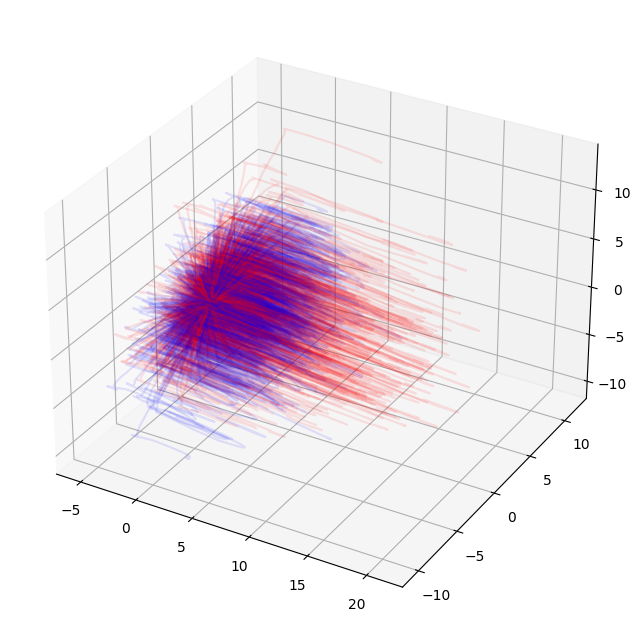

In [60]:
from mpl_toolkits import mplot3d
%matplotlib inline
plt.rcdefaults()
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 5))
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

for i in range(2048):
    activity_pc = pca.transform(activity_dict[i])
    ground_truth = out[i]
    color = 'red' if ground_truth == 0 else 'blue'
    _ = ax.plot3D(activity_pc[:, 0], activity_pc[:, 1], activity_pc[:, 2], '-', color=color, alpha=0.1)
    # if i < 20:
    #     _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], '-', color=color)


# Fixed points are shown in cross
# fixedpoints_pc = pca.transform(fixed_points[:, m_idx])
# plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', label='fixed points')

# ax1.set_xlabel('PC 1')
# ax1.set_ylabel('PC 2')
plt.show()

In [22]:
def visualize_fixed_points(fps, plot_ids=(0,), xs=None):
  for i in plot_ids:
    if xs is None:
      plt.plot(fps[i], label=f'FP-{i}')
    else:
      plt.plot(xs, fps[i], label=f'FP-{i}')
  plt.legend()
  plt.xlabel('Feature')
  plt.ylabel('Bump activity')
  plt.show()

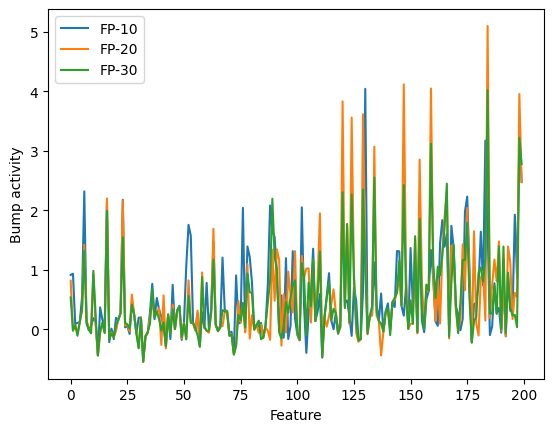

In [23]:
visualize_fixed_points(finder.fixed_points['h'],
                       plot_ids=(10, 20, 30),
                       )

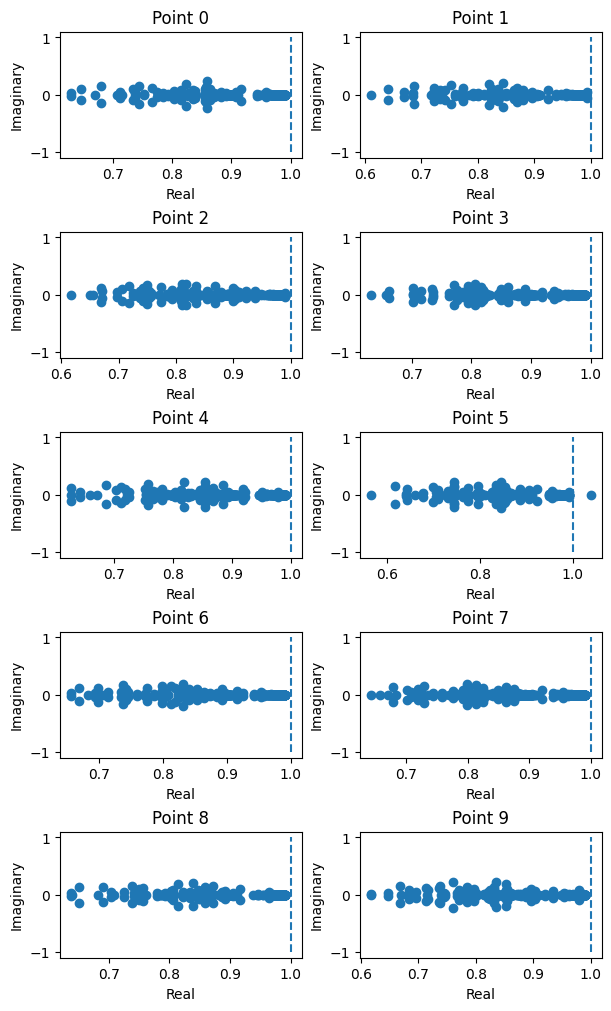

array([[[0.8       , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.8       , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.8       , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.8947495 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.98137677, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.8846056 ]],

       [[0.8       , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.8       , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.8       , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.8973017 ,
         0.        , 0.        ],
        [0. 

In [24]:
from jax import tree_map
fps = tree_map(lambda a: a[-10:], finder._fixed_points)
finder.compute_jacobians(fps, plot=True, num_col=2)